<a href="https://colab.research.google.com/github/recozers/Global_exp/blob/main/Global_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Explanation Plots

In this notebook we're going to take a look at some global explainable methods for machine learning models. These can be extremely useful in not just explaining your model but also diagnosing issues with it. Specifically we will look at PDP, ICE and ALE. These differ from LIME and SHAP because they look at the entire model and not simply one instance.

First lets load the relevant packages

In [ ]:
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

In [26]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
from alepython import ale_plot
import seaborn as sns

Now load the dataset. This dataset is a synthetic dataset based on Wharton's class of '25 admits to it's MBA program. We're going to build a simple logistic regression function and then interrograte the model to see what really matters for getting in to one of the most competitive programs in the country. Much of the reading I have done recently has emphasised how effective simple models can be, so we will just use 3 variables for this example.

In [14]:
df = pd.read_csv("MBA.csv")

df['admission'] = df['admission'].fillna(0)

df['admission'] = df['admission'].replace('Admit', 1)

df['admission'] = pd.to_numeric(df['admission'], errors='coerce')

df = df.dropna(axis=0, how='any', inplace=False)

y = df['admission']

X = df[['gpa', 'gmat', 'work_exp']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

You may wonder why we would use explainable methods on logistic regression which is already inherently interpretable? The answer is you probably normally wouldnt. I'm choosing to in this notebook because I think it will be interesting to compare the explanations with the actual weights. It also should be very intuitive.

In [36]:
logistic_model = LogisticRegression()

logistic_model.fit(X_train, y_train)

y_pred = logistic_model.predict(X_test)

acc = accuracy_score(y_pred, y_test)

feature_names = X_train.columns
weights_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': logistic_model.coef_.flatten()
})

print(weights_df)
print("Model accuracy:", acc)


    Feature  Coefficient
0       gpa     2.346746
1      gmat     0.017477
2  work_exp     0.009371
Model accuracy: 0.8436406067677946


This model seems to be assigning a lot of weight to the GPA, and not very much to the GMAT and almost nothing to work experience. Lets see how this compares with our explainable methods

# Partial Dependence Plot

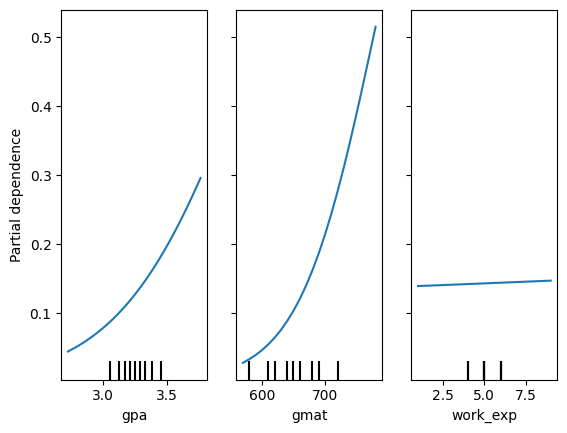

In [16]:
features = ['gpa', 'gmat', 'work_exp']

PartialDependenceDisplay.from_estimator(logistic_model, X, features,
    kind='average')

So a higher GPA and a higher GMAT have a very significant impact on your admission according to this plot. Work experience on the other hand has relatively little impact.

I mentioned earlier that these plots can help you diagnose errors in your model, have a quick look at the first PDP i got 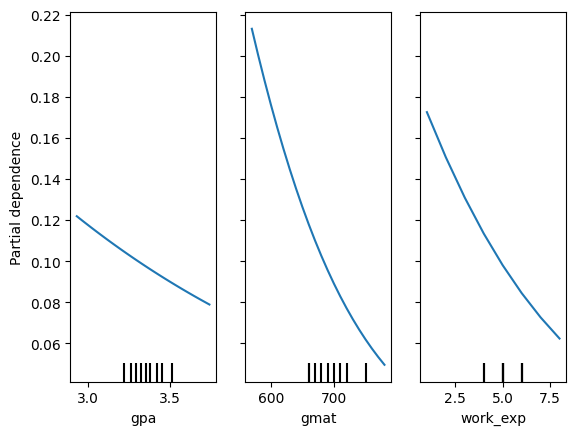

This obviously doesnt Make sense, Higher GPAs Are leading to less likely admission, Higher GMAT also? and work experience? This made no sense. I realised from looking at this plot that I had incorrectly preprocessed the data, I had dropped all 'na' values, when in fact a rejection is the null value for the admission column. So i was only looking at admission and waitlists.

# ICE

Individual condition explanation plots look a lot like PDP except they plot each individual instance and how different feature values would have afected their outcomes.

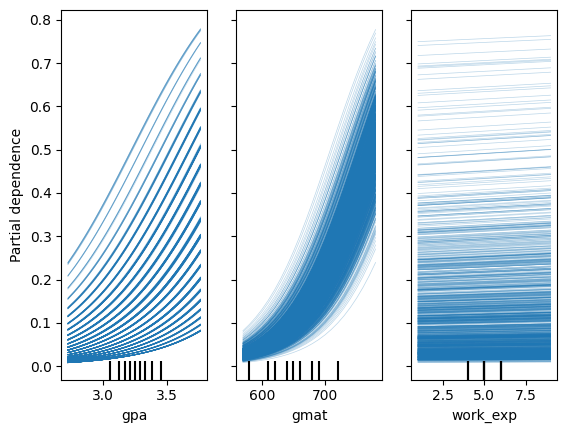

In [17]:
features = ['gpa', 'gmat', 'work_exp']

PartialDependenceDisplay.from_estimator(logistic_model, X, features,
    kind='individual')

Since this is synthetic data and a very simple model, its important to keep in mind that these plots dont usually look this clean. In reality we normally have more overlap and less clear trends. Here we see that GMAT can transform almost anyone in the dataset into an admittee. GPA on the other hand, seem to help the best candidates more, and the worst candidates rather little. Work experience remains somewhat unimportant.

# Correlation killed the partial dependence plot

If features are correlated, the PD/ICE plots cannot be trusted. This has the same intuition as why we can't trust the weights of regression models when features are correlated. Maybe the PDP tells us GMAT is really important, but its heavily correlated with GPA so its actuall inferring a higher GPA through the GMAT score. Lets look at the correlation matrix to cofirm, but I suspect that GPA and GMAT will be correlated.

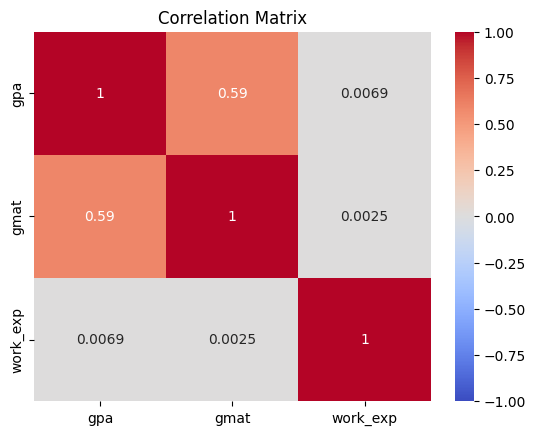

In [27]:
corr_mat = X.corr()

sns.heatmap(corr_mat, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

As expected, it seems like GMAT score and GPA scores are correlated. It would be strange if they weren't. For this reason we will use ALE plots. ALE plots compute local changes by considering the real distribution of the data. It might not be realistic to have a candidate with a GMAT of 600 and a GPA of 4.0, so it doesnt consider it.

# ALE plot

The ale function is still quite new so I had to create a predictor function to convert the predictions to 1/0 instead of Yes/No

In [18]:
def predictor(X):
    # Returns the probability of the positive class
    return logistic_model.predict_proba(X)[:, 1]

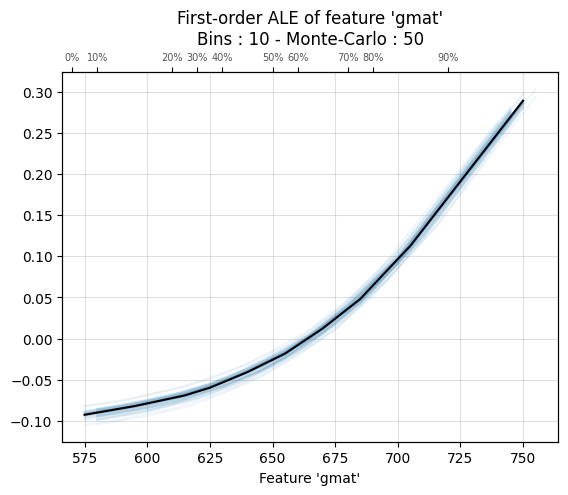

<Axes: title={'center': "First-order ALE of feature 'gmat'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'gmat'">

In [32]:
ale_plot(
    model=logistic_model,
    train_set=X_train,
    features=['gmat'],
    monte_carlo=True,
    predictor=predictor
)

This plot suggests that below a ~660 GMAT score your score will detract from the probability of admission. This steeply climbs however, the higher your GMAT.

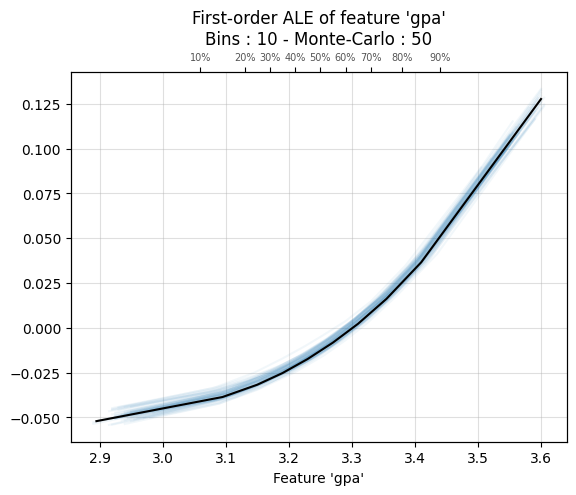

<Axes: title={'center': "First-order ALE of feature 'gpa'\nBins : 10 - Monte-Carlo : 50"}, xlabel="Feature 'gpa'">

In [28]:
ale_plot(
    model=logistic_model,
    train_set=X_train,
    features=['gpa'],
    monte_carlo=True,
    predictor=predictor
)

This plot shows us that GPA really does seem to be less important. A low GPA will still hurt you but not as much, and a high GPA will still help you but not as much as a high GMAT.

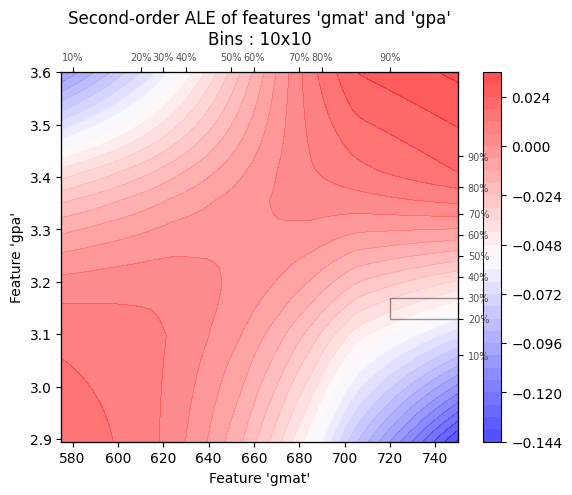

<Axes: title={'center': "Second-order ALE of features 'gmat' and 'gpa'\nBins : 10x10"}, xlabel="Feature 'gmat'", ylabel="Feature 'gpa'">

In [33]:
ale_plot(
    model=logistic_model,
    train_set=X_train,
    features=['gmat','gpa'],
    monte_carlo=True,
    predictor=predictor
)

This lot is almost exactly what we would expect, High GPA + High GMAT = higher chance of admission. But interestingly it also has a positive prediction for lower GPA and lower GMAT. A few things could be going on here. Firstly the model is likely to not have seen values in the extreme ends (although this should have been fixed by ALE). Its also possible that there are other confounding variables not in the model that mean that if you applied with such a low GPA and GMAT, you must have something amazing on your application to make up for it. The other possibility is i have done something incorrectly. Always a possibility!